In [6]:
import logging
logging.basicConfig(level=logging.DEBUG)

import PIL.Image
import graphcat.notebook
import numpy
import skimage

import imagecat.notebook

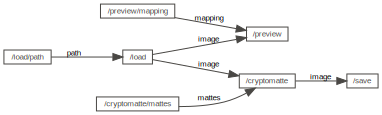

INFO:imagecat.operator:Task /load load:
INFO:imagecat.operator:  layers: *
INFO:imagecat.operator:  path: bunny_CryptoMaterial.exr
INFO:imagecat.operator:  output: Image(uCryptoMaterial.blue: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial.green: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial.red: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial00.alpha: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial00.blue: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial00.green: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial00.red: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial01.alpha: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial01.blue: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial01.green: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial01.red: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial02.alpha: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial02.blue: Layer(Role.NONE 1280x720x1 float32), uCryptoMaterial02.green: Layer(Role.NONE

Accordion(children=(HTML(value=''), HTML(value=''), HTML(value='')), _titles={'0': 'Layer: CryptoPreview', '1'…

In [7]:
mapping = {
    "CryptoPreview": {"role": imagecat.data.Role.RGB, "selection": ["uCryptoMaterial.red", "uCryptoMaterial.green", "uCryptoMaterial.blue"]},
    "CryptoRank0": {"role": imagecat.data.Role.REDGREEN, "selection": ["uCryptoMaterial00.red", "uCryptoMaterial00.green"]},
    "CryptoRank1": {"role": imagecat.data.Role.REDGREEN, "selection": ["uCryptoMaterial00.blue", "uCryptoMaterial00.alpha"]},
}

graph = graphcat.DynamicGraph()
imagecat.add_task(graph, "/load", imagecat.operator.load, path="bunny_CryptoMaterial.exr")
imagecat.add_task(graph, "/preview", imagecat.operator.remap, mapping=mapping)
imagecat.add_task(graph, "/cryptomatte", imagecat.operator.cryptomatte.decoder, mattes=["bunny_porcelain_mat"])
imagecat.add_task(graph, "/save", imagecat.operator.save)

imagecat.add_links(graph, "/load", ("/preview", "image"))
imagecat.add_links(graph, "/load", ("/cryptomatte", "image"))
imagecat.add_links(graph, "/cryptomatte", ("/save", "image"))

graphcat.notebook.display(graph)
imagecat.notebook.display(graph.output("/preview"), height="300px")

In [8]:
imagecat.notebook.display(graph.output("/cryptomatte"))

INFO:imagecat.operator.cryptomatte:Task /cryptomatte cryptomatte.decode:
INFO:imagecat.operator.cryptomatte:  cryptomatte: None
INFO:imagecat.operator.cryptomatte:  layer: M
INFO:imagecat.operator.cryptomatte:  mattes: ['bunny_porcelain_mat']
INFO:imagecat.operator.cryptomatte:  output: Image(M: Layer(Role.MATTE 1280x720x1 float32))


Accordion(children=(HTML(value=''),), _titles={'0': 'Layer: M'})

In [9]:
data = graph.output("/cryptomatte").layers["M"].data
data.shape

(720, 1280, 1)

`positive_orientation="high"` means that:

* Selected pixels are always to the *left* of the contour.
* Contours wind counter-clockwise around selected areas of the matte.
* Contours wind clockwise around unselected areas of the matte (holes).

In [10]:
import skimage.measure
contours = skimage.measure.find_contours(data[:,:,0], positive_orientation="high", level=0.5)

In [11]:
def ccw(polygon):
    result = 0
    for index, (y1, x1) in enumerate(polygon):
        y2, x2 = polygon[(index + 1) % len(polygon)]
        result += (x2 - x1) * (y2 + y1)
    return result > 0

In [12]:
for index, contour in enumerate(contours):
    print(index, contour.shape, ccw(contour))

0 (2587, 2) True
1 (173, 2) True
2 (5, 2) False
3 (7, 2) False
4 (5, 2) False
5 (5, 2) False
6 (27, 2) True
7 (37, 2) True
8 (19, 2) True
9 (5, 2) True
10 (7, 2) False
11 (37, 2) True
12 (27, 2) True
13 (15, 2) True
14 (5, 2) True
15 (11, 2) True
16 (19, 2) True


In [13]:
import skia
import IPython.display

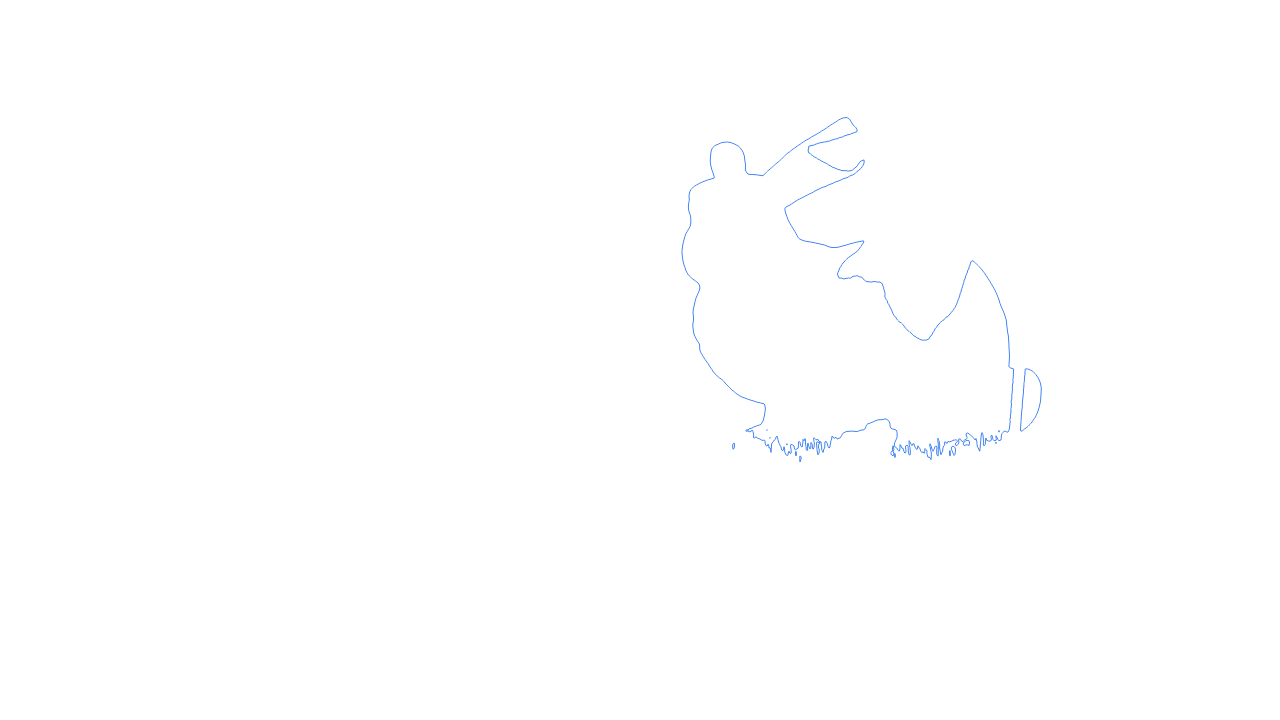

In [14]:
surface = skia.Surface(data.shape[1], data.shape[0])
canvas = surface.getCanvas()
canvas.drawColor(skia.ColorWHITE)
paint = skia.Paint(Style=skia.Paint.kStroke_Style, AntiAlias=True, StrokeWidth=1, Color=0xFF4285F4)
for contour in contours:
#    if not ccw(contour):
#        continue
    points = [skia.Point((point[1], point[0])) for point in contour]
    path = skia.Path()
    path.addPoly(points, close=True)
    canvas.drawPath(path, paint)
image = surface.makeImageSnapshot()
IPython.display.display(image)